In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hourly-electricity-consumption-and-production/electricityConsumptionAndProductioction.csv


# Intro
In this quick notebook we use a neural network based on a LST in order to do timeseries forecasting. For the dataset we will use the electricity consumption and production dataset.
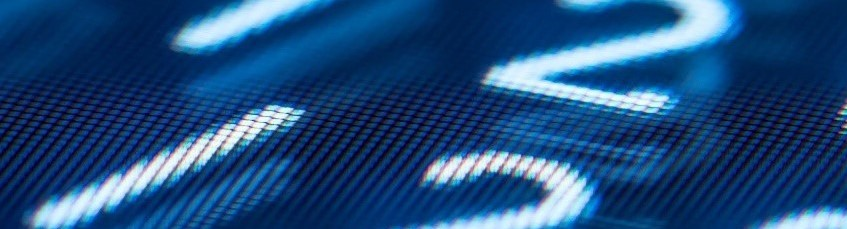

# Imports
We will add all the imports we need. We add the usual numpy, pandas and pyplot but also PyTorch and Lightning. 

In [2]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import pytorch_lightning as pl

In [3]:
# set the seeds in order to get predictable results
torch.manual_seed(200)
np.random.seed(200)

# set pandas to better show our data
pd.set_option('display.max_columns', None)
pd.set_option('expand_frame_repr', False)

# Loading the data and EDA
Let's load the data and do some 

In [4]:
df = pd.read_csv("/kaggle/input/hourly-electricity-consumption-and-production/electricityConsumptionAndProductioction.csv")

In [5]:
# also print the shape of our data
df.shape

(36772, 10)

In [6]:
df.head()

,DateTime,Consumption,Production,Nuclear,Wind,Hydroelectric,Oil and Gas,Coal,Solar,Biomass
0,2019-01-01 00:00:00,6352,6527,1395,79,1383,1896,1744,0,30
1,2019-01-01 01:00:00,6116,5701,1393,96,1112,1429,1641,0,30
2,2019-01-01 02:00:00,5873,5676,1393,142,1030,1465,1616,0,30
3,2019-01-01 03:00:00,5682,5603,1397,191,972,1455,1558,0,30
4,2019-01-01 04:00:00,5557,5454,1393,159,960,1454,1458,0,30


Let's quickly plot the data, this will demonstrate to us we are dealing with a forecastable timeseries.

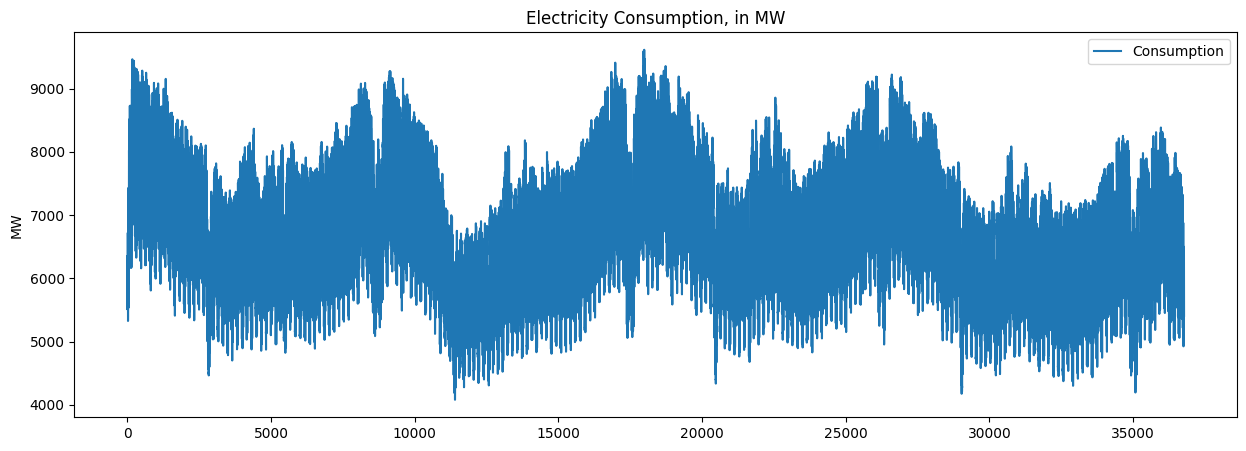

In [7]:
df[["Consumption"]].plot(style="-", figsize=(15, 5), title="Electricity Consumption, in MW")
plt.ylabel('MW')
plt.show()

# Preparing the data

In [8]:
sequenceSize = 10

# let's compute a cutoff index that will separate the training and the test data
testCutOffIndex = int(len(df) * 0.9)

# also we should keep test date times in order to later do some nice plotting
testDates = df[testCutOffIndex + sequenceSize: len(df)]["DateTime"]

df = df["Consumption"]

train = df[0: testCutOffIndex]
test = df[testCutOffIndex:]

# the scaler wants a bi dimensional array [[1], [2], [3]], insstead of [1, 2, 3]
train = train.to_numpy().reshape(-1, 1)
test = test.to_numpy().reshape(-1, 1)

In [9]:
# in order for our neural network to work better we should scale the values
scaler = StandardScaler()
train = scaler.fit_transform(train).flatten().tolist()
test = scaler.transform(test).flatten().tolist()

Next we will define a method that prepares the data by putting it in sequences. For our X we will keep a list of 10 elements (a windows) and for the y we will keep the value after the 10 elements from the X.

Let's say to the X we will add the vaues for indexes 0 - 9, and Y will have index 10. And this will "slide" to include all the values.

In [10]:
def toSequence(data, sequenceSize):
    X = []
    y = []

    for i in range(len(data) - sequenceSize):
        window = data[i: (i + sequenceSize)]
        target = data[i + sequenceSize]

        X.append(window)
        y.append(target)

    return torch.tensor(X, dtype=torch.float32).reshape(-1, sequenceSize, 1), torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

In [11]:
xTrain, yTrain = toSequence(train, sequenceSize)
xTest, yTest = toSequence(test, sequenceSize)

# Creating the Neural Network model
Now we will define the class that will be our model, for this we extend the LightningModule.

This the key of our exercise. 
The most important part if the definition our layers
- the LSTM layer, this is the tart of our network, we will use an input size of 1, as this is a regression problem
- a dropout layer, this will make the neural network more flexible and resilient to overfitting
- a first fully connected layer, this will take the output of the LSTM (and dropout) and dilute them
- a second fully connected layer, this will colapse to output to a single result


In [12]:
class ElectricityLstm(pl.LightningModule):
    def __init__(self):
        super(ElectricityLstm, self).__init__()

        self.lossFunction = nn.MSELoss()

        self.lstm = nn.LSTM(input_size=1, hidden_size=64, batch_first=True)
        self.droput = nn.Dropout(0.2)

        self.fc1 = nn.Linear(in_features=64, out_features=32)
        self.fc2 = nn.Linear(in_features=32, out_features=1)

    def forward(self, X):
        out, _ = self.lstm(X)
        out = out[:, -1, :]
        out = self.droput(out)
        out = self.fc1(out)
        out = self.fc2(out)

        return out


    def training_step(self, batch, batchIndex):
        X, y = batch
        out = self(X)
        loss = self.lossFunction(out, y)

        return {"loss": loss}

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

# Training the model
We will start this section by defining datasets and dataloaders for our data. Next we will train the model using the Lightning trainers.

In [13]:
train_dataset = TensorDataset(xTrain, yTrain)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(xTest, yTest)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [14]:
numberOfEpochs = 4

model = ElectricityLstm()

trainer = pl.Trainer(max_epochs = numberOfEpochs)

model.train()

trainer.fit(model, train_loader)

model.eval()

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

ElectricityLstm(
  (lossFunction): MSELoss()
  (lstm): LSTM(1, 64, batch_first=True)
  (droput): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)

# Computing the general loss
Here we the average loss for our predictions.

In [15]:
predictions = []
actualLabels = []

for batch in test_loader:
    X, y = batch
    prediction = model(X)

    predictions.extend(prediction.detach().numpy().flatten())
    actualLabels.extend(y.detach().numpy().flatten())

In [16]:
scaledPredictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
scaledYTest = scaler.inverse_transform(np.array(actualLabels).reshape(-1, 1))

In [17]:
averageLoss = np.sqrt(np.mean((scaledPredictions - scaledYTest) ** 2))
print(f"averageLoss: {averageLoss}")

averageLoss: 167.23760986328125


# Plotting the prediction vs. the real data
Now the pretty part, we will plot an overlay of the actual values and the predicted values. For this we will use the test dates that we saved at the beginning and we also plot just 200 elements.

(array([  0,  40,  80, 120, 160]),
 [Text(0, 0, '2022-10-11 06:00:00'),
  Text(40, 0, '2022-10-12 22:00:00'),
  Text(80, 0, '2022-10-14 14:00:00'),
  Text(120, 0, '2022-10-16 06:00:00'),
  Text(160, 0, '2022-10-17 22:00:00')])

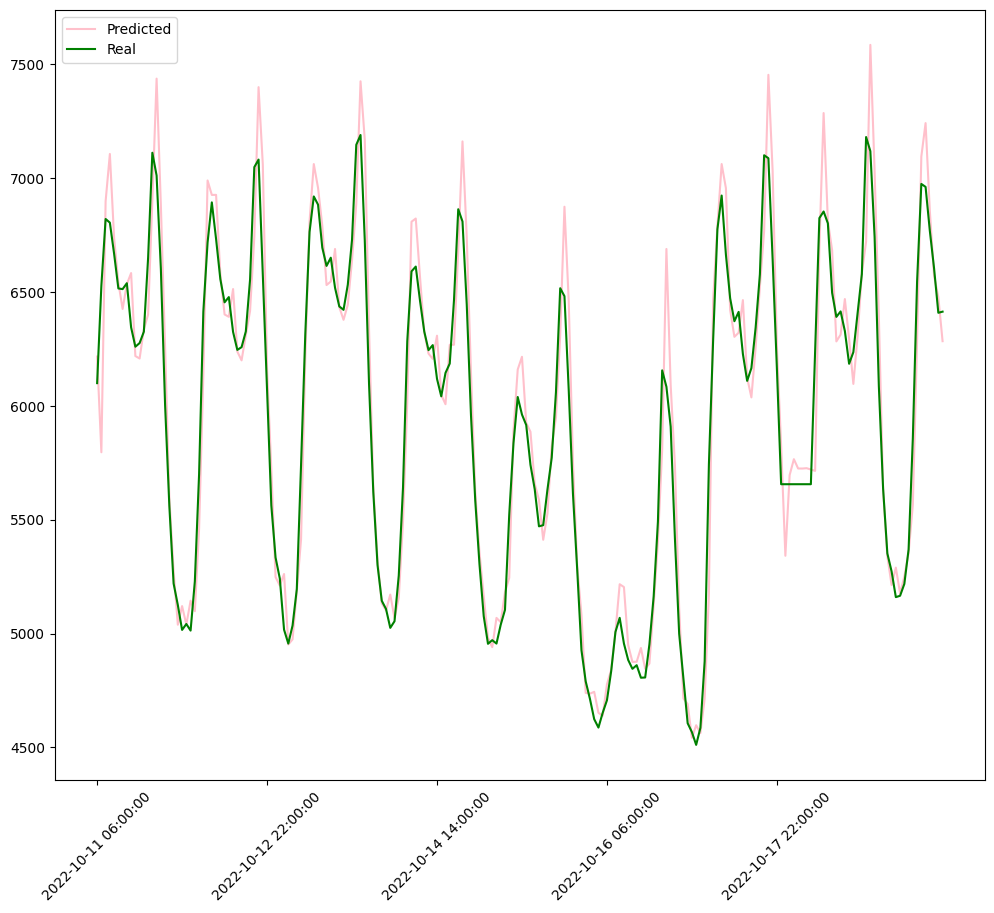

In [18]:
dataSetSize = 200

plt.figure(figsize=(12,10))
plt.plot(testDates[:dataSetSize], scaledPredictions[:dataSetSize], color= "pink")
plt.plot(testDates[:dataSetSize], scaledYTest[:dataSetSize], color= "green")
plt.legend(["Predicted", "Real"])
plt.xticks(np.arange(0, dataSetSize, round((dataSetSize / 5)/10)*10))
plt.xticks(rotation=45)

# Finish
You have maded it to the finish, thank you. Please upvote if you liked this :)